# Face Recognition Project

### Model training

To train face recognition model on any facial dataset images must be aligned first. This step is very important to achieve a good quality of face recognition.
Here's an example of what we would get after alignment of all the images of Aaron Peirsol from our dataset:

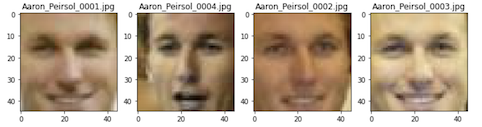

### Dataset 

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). But we'll use a version of it that has all the images in it aligned and cropped. You can download the dataset using this link: https://disk.yandex.ru/d/S8f03spLIA1wrw or using the code below:

In [1]:
# ! pip install wldhx.yadisk-direct
# ! curl -L $(yadisk-direct https://disk.yandex.ru/d/S8f03spLIA1wrw) -o celebA_train.zip
# ! unzip -qq celebA_train.zip

Let's look at the data first:

In [2]:
#!ls celebA_train_500/

- celebA_imgs — folder with aligned images 
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [3]:
import os
import cv2
import numpy as np
import gc
from PIL import Image
from skimage import io, transform
import seaborn as sns

import torch
from torch import nn
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights, resnet50

from torch.utils.data import Dataset

from sklearn.metrics.pairwise import cosine_similarity as cossk

import matplotlib.pyplot as plt


Let's visualize some images to understand what we're dealing with:

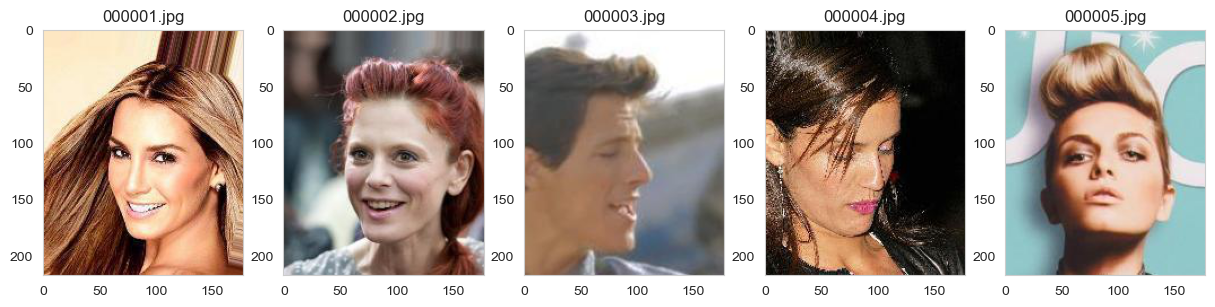

In [4]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
      img = Image.open(os.path.join('celebA_train_500/celebA_train_500/celebA_imgs/', img))
      imgs.append(np.array(img))


    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axis.grid(False)
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()


images_names = os.listdir('celebA_train_500/celebA_train_500/celebA_imgs/')[:5]
show_imgs(images_names)


### Train Neural Network

Let's build a Datasets and network using this images:

In [5]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_500/celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('celebA_train_500/celebA_imgs/', filename))
    
    return np.array(images_paths)


class celebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_500/celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name) 
        
        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'image': image,
                'label': label,
            }
        
        sample['image'] = self.transform(sample['image'])

        return sample

In [6]:
transform = transforms.Compose([
      transforms.Resize(300),
      transforms.CenterCrop(224),
      #transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_train = transforms.Compose([

    transforms.Resize(300),
    transforms.CenterCrop(224),
    #transforms.Resize(160),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_data = celebADataset('train', transform_train)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)


batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
weights = ResNet50_Weights.DEFAULT

In [11]:
model = resnet50(weights=weights)

In [13]:
ct = 0
for child in model.children():
    ct += 1
    if ct < 5:
        for param in child.parameters():
            param.requires_grad = False

In [14]:
model.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(inplace=True),
    nn.Linear(1000, 500)
    ).to(device)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
model.to('cuda');

In [16]:
def train(model, dataloader, loss_fn, optimizer, num_epochs=36, scheduler=scheduler):
    num_elements = 0

    for epoch in range(num_epochs):
        model.train()
        print(f'Epoch{epoch}')
        running_loss = 0
        running_corrects = 0
        val_corrects = 0

        for i, batch in enumerate(dataloader):
            X_batch, y_batch = batch['image'], batch['label']
            num_elements += len(y_batch)
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')

            optimizer.zero_grad()

            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_batch.size(0)
            running_corrects += torch.sum(preds == y_batch)

        if epoch %2 == 0:
            with torch.no_grad():
                val_elements = 0
                for i, batch in enumerate(val_loader):
                    X_batch, y_batch = batch['image'], batch['label']
                    val_elements += len(y_batch)
                    X_batch = X_batch.to('cuda')
                    y_batch = y_batch.to('cuda')
                    out_val = model(X_batch)
                    loss_val = loss_fn(out_val, y_batch)
                    _, preds = torch.max(out_val, 1)
                    val_corrects += torch.sum(preds == y_batch)

                print('Val Accuracy = ', val_corrects / val_elements)


        print('{} Loss: {:.4f} Acc: {:.4f}'.format(epoch, running_loss, running_corrects))
        scheduler.step(loss)
    val_acc_history = running_corrects / num_elements
    return model, val_acc_history

In [17]:
#train(model, train_loader, loss_fn, optimizer)

Epoch0
Val Accuracy =  tensor(0.0250, device='cuda:0')
0 Loss: 52122.8513 Acc: 58.0000
Epoch1
1 Loss: 39328.0012 Acc: 979.0000
Epoch2
Val Accuracy =  tensor(0.3232, device='cuda:0')
2 Loss: 23379.6113 Acc: 3344.0000
Epoch3
3 Loss: 13115.3027 Acc: 5545.0000
Epoch4
Val Accuracy =  tensor(0.4494, device='cuda:0')
4 Loss: 7138.8675 Acc: 6986.0000
Epoch5
5 Loss: 3839.7560 Acc: 7738.0000
Epoch6
Val Accuracy =  tensor(0.4915, device='cuda:0')
6 Loss: 2026.1746 Acc: 8174.0000
Epoch7
7 Loss: 1105.3284 Acc: 8392.0000
Epoch8
Val Accuracy =  tensor(0.5288, device='cuda:0')
8 Loss: 645.7145 Acc: 8461.0000
Epoch9
9 Loss: 342.5458 Acc: 8519.0000
Epoch10
Val Accuracy =  tensor(0.5548, device='cuda:0')
10 Loss: 227.0169 Acc: 8531.0000
Epoch11
11 Loss: 156.5758 Acc: 8538.0000
Epoch12
Val Accuracy =  tensor(0.5469, device='cuda:0')
12 Loss: 107.5615 Acc: 8539.0000
Epoch13
13 Loss: 66.5191 Acc: 8544.0000
Epoch14
Val Accuracy =  tensor(0.5634, device='cuda:0')
14 Loss: 49.0701 Acc: 8544.0000
Epoch15
15 Los

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1,

Code for model evaluating (you can modify it if you want):

In [18]:
def evaluate(model, dataloader, loss_fn):
    model.eval()
    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):
        
        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)

        with torch.no_grad():
            logits = model(X_batch.to(device))
            
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())
            
            y_pred = torch.argmax(logits, dim=1)
            
            num_correct += torch.sum(y_pred.cpu() == y_batch)
    
    accuracy = num_correct / num_elements
            
    return accuracy.numpy(), np.mean(losses)

In [19]:
test_accuracy, test_loss = evaluate(model, test_loader, loss_fn)
test_accuracy, test_loss

(array(0.6941473, dtype=float32), 1.5923701572418212)

69.4% Okay

In [21]:
torch.save(model, 'model.pth')

In [22]:
model = torch.load('model.pth')
model.eval();

**Cosine similarity calculation**

In [20]:
model.fc = nn.Sequential(*list(model.fc.children())[:-2])

In [24]:
cos = nn.CosineSimilarity()

In [25]:
model.to(device)
model.eval();
num_persons = 500
emb_train_list = []
emb_test_list = []



from collections import defaultdict
embed_dict = defaultdict(list)
embed_dict_test = defaultdict(list)
def fill_embed_for_user(x_batch, y_batch):
    dummy_dict = [y_batch, model(x_batch).to('cpu').detach().numpy()[0]]
    return dummy_dict

In [26]:
person_indices = np.where(np.isin(train_data.labels, range(num_persons)))
embeds_ = [fill_embed_for_user(train_data.__getitem__(i)['image'].to(device).unsqueeze(0),
                              train_data.__getitem__(i)['label']) for i in person_indices[0]]

In [27]:
for k, v in embeds_:
    embed_dict[k].append(v)

In [28]:
person_indices = np.where(np.isin(test_data.labels, range(num_persons)))
embeds_ = [fill_embed_for_user(test_data.__getitem__(i)['image'].to(device).unsqueeze(0),
                               test_data.__getitem__(i)['label']) for i in person_indices[0]]

In [29]:
for k, v in embeds_:
    embed_dict_test[k].append(v)

In [30]:
self_dist = []
test_distance = []
for user in embed_dict:
    try:
        self_cos = cossk(np.array(embed_dict[user]), np.array(embed_dict[user]))
        self_dist.append(self_cos.mean())

        self_test_cos = cossk(np.array(embed_dict[user]), np.array(embed_dict_test[user]))
        test_distance.append(self_test_cos.mean())
    except ValueError:
        pass

In [31]:
print(np.mean(self_dist), np.mean(test_distance))

0.9217041 0.8657322


In general embeddings from the train set have 92% similarity with each other and 86% similarity with embeddings of the same person from the test set.

In [32]:
torch.cuda.empty_cache()

**Cosine similarity distribution**

In [33]:
diff_dict = []
diff_test = []
for i in range(10):
    for user in embed_dict:
        if user != i:
            try:
                diff_cos = cossk(np.array(embed_dict_test[user]), np.array(embed_dict[i]))
                diff_dict.append(diff_cos.mean())
            except ValueError:
                pass

In [34]:
np.mean(diff_dict)

0.5691915

in general others embeddings are 60% similar.

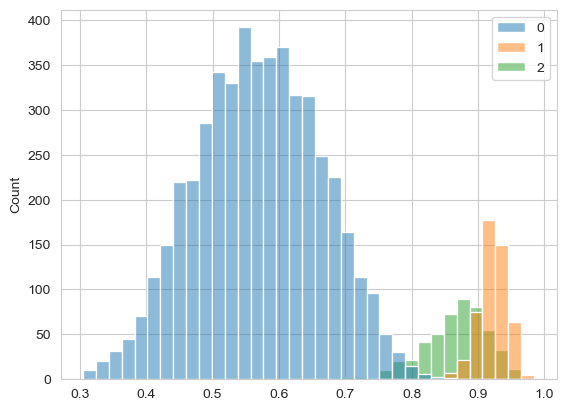

In [35]:
sns.histplot([diff_dict, self_dist, test_distance]);